In [1]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from visturing.properties.prop3_4 import load_data, load_ground_truth
from visturing.ranking import prepare_data, calculate_correlations_with_ground_truth, calculate_correlations, prepare_and_correlate, prepare_and_correlate_order, calculate_spearman

In [3]:
x_gt, y_gt, rg_gt, yb_gt = load_ground_truth("../../ground_truth_decalogo")

In [4]:
root_path = "../../Data/Experiment_4_5"

In [5]:
noises = {p.split("/")[-1].split(".")[0].split("_")[-1]:np.load(p) for p in glob(os.path.join(root_path, "*")) if "noises" in p}
for k,v in noises.items(): print(k, v.shape)

yb (10, 40, 256, 256, 3)
rg (10, 40, 256, 256, 3)
a (10, 40, 256, 256, 3)


In [6]:
# bg = {p.split("/")[-1].split(".")[0].split("_")[-1]:np.load(p) for p in glob(os.path.join(root_path, "*")) if "background" in p}
bg = np.load(os.path.join(root_path, "background.npy"))
bg.shape

(256, 256, 3)

In [7]:
import json

import jax
from jax import random, numpy as jnp
import flax
from huggingface_hub import hf_hub_download
from ml_collections import ConfigDict

from paramperceptnet.models import Baseline as PerceptNet
from paramperceptnet.configs import param_config

In [8]:
model_name = "ppnet-baseline"

In [9]:
config_path = hf_hub_download(repo_id=f"Jorgvt/{model_name}",
                              filename="config.json")
with open(config_path, "r") as f:
    config = ConfigDict(json.load(f))

In [10]:
from safetensors.flax import load_file

weights_path = hf_hub_download(repo_id=f"Jorgvt/{model_name}",
                               filename="weights.safetensors")
variables = load_file(weights_path)
variables = flax.traverse_util.unflatten_dict(variables, sep=".")
params = variables["params"]

In [11]:
model = PerceptNet(config)

In [12]:
params.keys()

dict_keys(['Color', 'Conv_0', 'Conv_1', 'GDN_0', 'GDN_1', 'GDN_2', 'GDN_3'])

In [13]:
layer = "GDN_3"

In [14]:
@jax.jit
def calculate_diffs(img1, img2):
    _, extra_a = model.apply({"params": params}, img1, train=False, capture_intermediates=True)
    _, extra_b = model.apply({"params": params}, img2, train=False, capture_intermediates=True)
    a = extra_a["intermediates"][layer]["__call__"][0]
    b = extra_b["intermediates"][layer]["__call__"][0]
    return ((a-b)**2).mean(axis=(1,2,3))**(1/2)

In [15]:
diffs = {}
for k, noises_ in noises.items():
    diffs_it = []
    for noise_it in noises_:
        diff = calculate_diffs(noise_it, bg[None,...])
        # print(noise_it.shape, bg.shape, diff.shape)
        diffs_it.append(diff)
        # break
    diffs_it = np.array(diffs_it)
    diffs[k] = diffs_it.mean(axis=0)
    # break

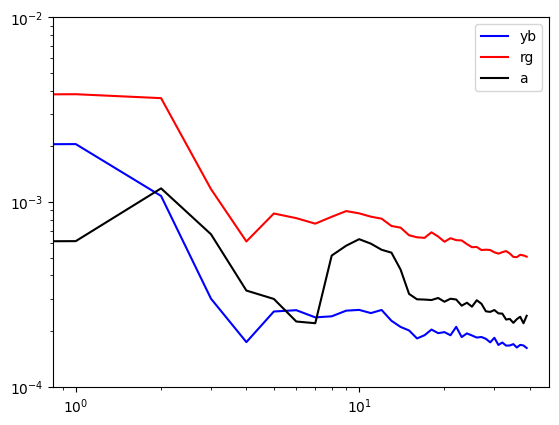

In [16]:
fig, ax = plt.subplots()
for k, v in diffs.items():
    if k == "a": color = "k"
    elif k == "rg": color = "red"
    elif k == "yb": color = "blue"
    ax.plot(v, label=k, color=color)
plt.xscale("log")
plt.yscale("log")
plt.ylim([1e-4,1e-2])
plt.legend()
plt.show()

In [24]:
gt_s = np.stack([y_gt,
                 rg_gt,
                 yb_gt])
gt_s.shape

(3, 50)

In [19]:
diffs_s = np.stack([diffs["a"],
                    diffs["rg"],
                    diffs["yb"]])
diffs_s.shape

(3, 40)

In [23]:
freqs = load_data("../..//Data/Experiment_4_5")
freqs.shape

(40,)

In [28]:
bs, ds = [], []
for d, gt in zip(diffs_s, gt_s):
    a, b, c, d = prepare_data(freqs, d, x_gt, gt)
    bs.append(b)
    ds.append(d)
b = np.array(bs)
d = np.array(ds)
a.shape, b.shape, c.shape, d.shape

((40,), (3, 40), (40,), (3, 40))

In [31]:
calculate_correlations_with_ground_truth(b, d)

{'spearman': np.float64(0.4375),
 'kendall': np.float64(0.29895833333333327),
 'pearson': np.float64(0.4375)}

In [32]:
import scipy.stats as stats

In [34]:
stats.pearsonr(b.ravel(), d.ravel())

PearsonRResult(statistic=np.float64(0.353321150239347), pvalue=np.float64(7.545959661327751e-05))